In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter


In [3]:
def cost_function(x, nqubits):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
   
    for k in range(1,nqubits):
        tmp = 0
        for i in range(1,nqubits-k+1):
            tmp += (2*int(x[i-1])-1)*(2*int(x[i+k-1])-1)
        obj += tmp**2
    
            
    return obj


def compute_expectation(counts,  nqubits):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = cost_function(x=bitstring, nqubits=nqubits)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(theta,nqubits):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    p = int(len(theta)/2)
    #p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    #print(theta,beta,gamma)
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        fourfactors = np.exp(-1j * 2 * gamma[irep] * np.array([1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]))
        
        # problem unitary
        for k in range(1,nqubits):
            for i in range(0, nqubits-k):
                qc.rzz(4 * gamma[irep], i, i+k)
            for i in range(0, nqubits-k):
                for j in range(i + 1, nqubits-k):
                    if i + k != j:
                        qc.diagonal(list(fourfactors), qubit=[i, i+k, j, j+k])

       
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(nqubits, p,shots=4096):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    shots = max(shots, 2**nqubits)
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta=theta,nqubits=nqubits)
        counts = backend.run(circuits = qc, seed_simulator=1, 
                             nshots=shots).result().get_counts()
        
        return compute_expectation(counts=counts,nqubits=nqubits)
    
    return execute_circ


In [4]:
from scipy.optimize import minimize

nqubits = 5
expectation = get_expectation(nqubits=nqubits, p=1)
p0= np.random.uniform(size = 20)
res = minimize(expectation, 
                x0 = p0,
               method='COBYLA')
res

     fun: 2.7265625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 249
  status: 1
 success: True
       x: array([ 0.41294759,  1.15268169,  0.33558795,  1.81858344,  1.5480238 ,
        0.8080348 ,  0.95141834,  0.12391262, -0.0023688 , -0.03627421,
        0.71997374,  0.51892862,  0.60096781,  0.35517154,  0.39588174,
        0.02445126,  0.52702034,  0.74269787,  1.13849587,  0.75320772])

In [5]:
from qiskit.visualization import plot_histogram

shots = min(4096*10,2**nqubits)
backend = Aer.get_backend('aer_simulator')


qc_res = create_qaoa_circ(res.x,nqubits)

counts = backend.run(qc_res, seed_simulator=10, shots = 2*4096).result().get_counts()

if nqubits < 6:
    plot_histogram(counts)

In [6]:
dict(sorted(counts.items(), key=lambda item: item[1]))

{'11011': 1,
 '01111': 1,
 '11111': 1,
 '01101': 1,
 '10000': 1,
 '01001': 2,
 '10110': 2,
 '00000': 2,
 '00100': 2,
 '00001': 2,
 '00111': 2,
 '00011': 3,
 '11110': 4,
 '01100': 4,
 '00110': 4,
 '11000': 5,
 '10010': 5,
 '11001': 5,
 '11100': 6,
 '10011': 7,
 '01010': 8,
 '10101': 11,
 '11010': 151,
 '10100': 181,
 '01110': 182,
 '01011': 187,
 '00101': 192,
 '10001': 192,
 '00010': 1704,
 '01000': 1730,
 '11101': 1796,
 '10111': 1798}

In [7]:
c = 0
for key in counts.keys():
    c += counts[key]
print(c)

8192


Text(0, 0.5, 'Counts')

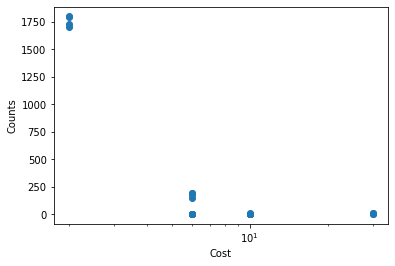

In [8]:
res_theo = []
res_opt = []
for key in counts.keys():
    res_theo.append(cost_function(key, nqubits))
    res_opt.append(counts[key])
    
plt.scatter(res_theo,res_opt)
plt.xscale('log')
plt.xlabel('Cost')
plt.ylabel('Counts')

# Test

In [9]:
import itertools

all_conf = np.array([np.array(i) for i in itertools.product([0, 1], repeat = nqubits)])

res_theo = []
for x in all_conf:

        
    res_theo.append(cost_function(x, nqubits))

res_theo = np.array(res_theo)
    
ind = np.where(res_theo == res_theo.min())
    
print(all_conf[ind])
print(res_theo.min())


[[0 0 0 1 0]
 [0 1 0 0 0]
 [1 0 1 1 1]
 [1 1 1 0 1]]
2
